In [1]:
import json
import pickle
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import xml.etree.ElementTree as ET

# Parse the XML file
tree = ET.parse("./dataset/cwe.xml")
root = tree.getroot()
ns = {"cwe": "http://cwe.mitre.org/cwe-7"} # Define namespace
cwe_dict = {weakness.get("ID"): weakness for weakness in root.findall(".//cwe:Weakness", ns)}

def find_parents_dict(cwe_id:str):    
    result = {"Pillar": [], "Class": [], "Base": [], "Variant": []}
    
    current_cwe_id = cwe_id
    while current_cwe_id:    
        # Find the Weakness element
        weakness = cwe_dict.get(current_cwe_id)
        if not weakness:
            return None  # If CWE is not found, stop the search

        abstraction = weakness.get("Abstraction")
        if (result.get(abstraction, None)) is not None:
            result[abstraction].append('CWE-'+current_cwe_id)
        
        # Check if the weakness abstraction is "Pillar"
        if abstraction == "Pillar": break

        # Find the Parent CWE (ChildOf relation)
        related_weaknesses = weakness.find("cwe:Related_Weaknesses", ns)
        if related_weaknesses is not None:
            for related in related_weaknesses.findall("cwe:Related_Weakness", ns):
                if related.get("Nature") == "ChildOf":
                    current_cwe_id = related.get("CWE_ID")
        else: break
    
    return result

In [3]:
with open('./dataset/test_pickles/test_non_vuln.pkl', 'rb') as file:
    non_vuln_df = pickle.load(file)
    
with open('./dataset/test_pickles/test_vuln.pkl', 'rb') as file:
    vuln_df = pickle.load(file)

# df = pd.concat([non_vuln_df, vuln_df], ignore_index=True)
    
print(len(non_vuln_df))
print(len(vuln_df))
# print(len(df))

90
450


In [4]:
cot_vuln_path = './result/baseline_cot/cot_vuln_code_results.json'
cot_non_vuln_path = './result/baseline_cot/cot_non_vuln_code_results.json'
fs_vuln_path = './result/baseline_fs/fs_vuln_result_retry.json'
fs_non_vuln_path = './result/baseline_fs/fs_non_vuln_result_retry.json'
FT_cot_vuln_path = './result/FT_cot/FT_cot_vuln_retry.json'
FT_cot_non_vuln_path = './result/FT_cot/FT_cot_non_vuln_retry.json'
FT_fs_vuln_path = './result/FT_fs/FT_fs_vuln_retry.json'
FT_fs_non_vuln_path = './result/FT_fs/FT_fs_non_vuln_retry.json'


with open(FT_fs_vuln_path, 'r') as file:
    vuln_result = json.load(file)

with open(FT_fs_non_vuln_path, 'r') as file:
    non_vuln_result = json.load(file)
    
print(len(vuln_result))
print(len(non_vuln_result))

1800
360


In [5]:
vuln_result[:3]

[{'file_change_id': '204963180360770',
  'vuln_type': 'CWE-20',
  'result': '{"is_this_vuln":true,"vuln_code_part":"part","reason":"This is a part of the vu ln code.","cwe":{"cwe_id":"CWE-352","name":"Cross-site Request Forgery (CSRF)","description":"The software does not reject or ignore, without generating an error message, at least one unexpected or inappropriate argument(s) to a function.\\r\\n\\r\\nThis weakness may lead to a situation where an attacker can provide data in a way that causes the application to perform actions that are contrary to intended behavior. For example, providing input designed to bypass authorization checks could result in disclosure of unauthorized information or worse, a denial of service condition if critical resources are consumed as part of processing the input.\\r\\n\\r\\nThis weakness is prevalent in software that processes user-supplied data without attempting to block or reject input or input-processing errors. This weakness results from a common 

In [6]:
# Add Class to results

for r in non_vuln_result:
    r['class'] = 'non_vuln'
    
    file_id = r['file_change_id']
    lang_cwe_series = non_vuln_df[non_vuln_df['file_change_id'] == file_id]['programming_language']
    if not lang_cwe_series.empty:  # Avoid IndexError
        lang = lang_cwe_series.iloc[0]  # Extract first value
        r['lang'] = lang
    else:
        r['lang'] = lang
        print(f"No match (lang) found for file_change_id: {file_id}")

for r in vuln_result:
    file_id = r['file_change_id']
    class_cwe_series = vuln_df[vuln_df['file_change_id'] == file_id]['class']
    lang_cwe_series = vuln_df[vuln_df['file_change_id'] == file_id]['programming_language']
    
    if not class_cwe_series.empty:  # Avoid IndexError
        class_cwe = class_cwe_series.iloc[0]  # Extract first value
        r['class'] = class_cwe
    else:
        r['class'] = class_cwe
        print(f"No match found for file_change_id: {file_id}")
        
    if not lang_cwe_series.empty:  # Avoid IndexError
        lang = lang_cwe_series.iloc[0]  # Extract first value
        r['lang'] = lang
    else:
        r['lang'] = lang
        print(f"No match (lang) found for file_change_id: {file_id}")

In [7]:
import re
import json

def purify_results(results):
    # Define the cyclic order of models
    # models = ['llama3.1:8b', 'codellama:7b', 'phi4:14b', 'deepseek-r1:14b']
    models = ['hf.co/Kei5uke/llama3:latest', 'hf.co/Kei5uke/codellama:latest', 'hf.co/Kei5uke/phi4:latest', 'hf.co/Kei5uke/deepseek:latest']
    
    # Filter CWE-num only
    for index, result in enumerate(results):
        # Assign models in a cyclic manner
        result['model'] = models[index % len(models)]  # Cycle through the models list

        # Check if result['result'] is a string and parse it if necessary
        if isinstance(result.get('result'), str):
            try:
                result['result'] = json.loads(result['result'])  # Parse JSON string
            except json.JSONDecodeError:
                # Handle invalid JSON (e.g., log an error or skip this result)
                print(f"Invalid JSON in result['result']: {result['result']}")
                result['result'] = {}
                continue

        # Ensure result['result'] is a dictionary (handle None or missing cases)
        if result.get('result') is None:
            result['result'] = {}

        # Now result['result'] is guaranteed to be a dictionary
        cwe = result['result'].get('cwe', {})  # Use .get() to safely access 'cwe'

        # If cwe is a string, convert it to a dictionary with 'cwe_id' as the key
        if isinstance(cwe, str):
            cwe = {'cwe_id': cwe}

        if cwe is not None:
            cwe_string = cwe.get('cwe_id', '')  # Ensure it's a string
            if 'CWE-' in cwe_string:
                match = re.search(r'CWE-\d+', cwe_string, re.IGNORECASE)
                if match:
                    result['result']['cwe'] = {'cwe_id': match.group()}  # Set valid CWE
                else:
                    result['result']['cwe'] = {'cwe_id': 'unknown'}  # Set default safe value
            else:
                result['result']['cwe'] = {'cwe_id': 'unknown'}  # Handle invalid cases

    return results

results = non_vuln_result + vuln_result
results = purify_results(results)

In [8]:
results[100]

{'file_change_id': '22521974684915',
 'vuln_type': 'non_vuln',
 'result': {'is_this_vuln': False,
  'vuln_code_part': '',
  'reason': '',
  'cwe': None},
 'model': 'hf.co/Kei5uke/llama3:latest',
 'version': 1,
 'error': False,
 'time': 12.235174278961495,
 'class': 'non_vuln',
 'lang': 'JavaScript'}

In [9]:
len(results)

2160

In [10]:
def extract_labels(results, model):
    """Extract true and predicted labels for a given model."""
    true_labels = []
    true_class_labels = []
    pred_labels = []

    for r in results:
        if r['model'] == model:
            true_labels.append(r['vuln_type'])
            true_class_labels.append(r['class'])
            # print(r['result'])
            vuln_exist_pred = r['result'].get('is_this_vuln', '')
            if vuln_exist_pred:
                cwe_exist_pred = r['result'].get('cwe')
                if cwe_exist_pred:
                    cwe_id = cwe_exist_pred.get('cwe_id', 'unknown')
                    pred_labels.append(cwe_id)
                else:
                    pred_labels.append('unknown')
            else:
                pred_labels.append('non_vuln')

    return true_labels, true_class_labels, pred_labels

def map_cwe_to_class(pred_labels, find_parents_dict):
    """Map CWE labels to their parent classes."""
    unique_labels = np.unique(pred_labels)
    unique_cwe_class = {}

    for cwe in unique_labels:
        if 'CWE-' in cwe:
            parents = find_parents_dict(cwe.split('-')[1])
            class_cwe = parents['Class'][-1] if parents and len(parents['Class']) > 0 else None
            if class_cwe is not None:
                unique_cwe_class[cwe] = class_cwe

    return unique_cwe_class

def compute_confusion_matrix(model, true_class_labels, pred_class_labels_filterd, all_labels, show=True):
    """Compute and plot the confusion matrix with proper label ordering."""
    # Define label ordering explicitly
    true_labels_order = ['non_vuln','CWE-20','CWE-287','CWE-400','CWE-668','CWE-74']
    pred_labels_order = ['non_vuln','CWE-20','CWE-287','CWE-400','CWE-668','CWE-74',
                        'Other CWE','unknown']

    cm = confusion_matrix(true_class_labels, pred_class_labels_filterd, 
                         labels=all_labels)
    
    # Filter and reorder rows/columns
    row_indices = [all_labels.index(l) for l in true_labels_order]
    col_indices = [all_labels.index(l) for l in pred_labels_order]
    cm_ordered = cm[row_indices, :][:, col_indices]

    # Calculate percentages with epsilon to avoid division by zero
    cm_percent = cm_ordered.astype('float') / cm_ordered.sum(axis=1)[:, np.newaxis] + 1e-6
    cm_percent = cm_percent * 100

    # Create annotation labels
    labels = []
    for i in range(len(true_labels_order)):
        row = []
        for j in range(len(pred_labels_order)):
            count = cm_ordered[i, j]
            perc = cm_percent[i, j]
            row.append(f"{count}\n({perc:.1f}%)" if count > 0 else "0\n(0.0%)")
        labels.append(row)

    # Plot with correct ordering
    if show:
        plt.figure(figsize=(12, 8), dpi=300)
        sns.heatmap(cm_ordered, annot=labels, fmt='', cmap='Blues',
                    xticklabels=pred_labels_order,
                    yticklabels=true_labels_order)
        
        # Reverse y-axis to show 'non_vuln' at bottom
        plt.gca().invert_yaxis()
        
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('Actual', fontsize=12)
        plt.title(f'Confusion Matrix: {model}', pad=20, fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    return cm_ordered

def compute_metrics(cm, all_labels, true_labels_order, pred_labels_order):
    """Compute TP, FP, FN, TN, Precision, Recall, F1-score, and Accuracy."""
    # Initialize metrics
    TP = np.zeros(len(true_labels_order))
    FP = np.zeros(len(true_labels_order))
    FN = np.zeros(len(true_labels_order))
    TN = np.zeros(len(true_labels_order))

    # Compute TP, FP, FN, TN for each class
    for i, label in enumerate(true_labels_order):
        TP[i] = cm[i, pred_labels_order.index(label)] if label in pred_labels_order else 0
        FP[i] = np.sum(cm[:, pred_labels_order.index(label)]) - TP[i] if label in pred_labels_order else 0
        FN[i] = np.sum(cm[i, :]) - TP[i]
        TN[i] = np.sum(cm) - (TP[i] + FP[i] + FN[i])

    # Compute per-class Precision, Recall, and F1-score
    precision_per_class = TP / (TP + FP + 1e-6)  # Add epsilon to avoid division by zero
    recall_per_class = TP / (TP + FN + 1e-6)
    f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + 1e-6)

    # Handle NaN values (due to division by zero in empty classes)
    precision_per_class = np.nan_to_num(precision_per_class, nan=0.0)
    recall_per_class = np.nan_to_num(recall_per_class, nan=0.0)
    f1_per_class = np.nan_to_num(f1_per_class, nan=0.0)

    # Compute Macro Metrics (Average over all classes)
    macro_precision = np.mean(precision_per_class)
    macro_recall = np.mean(recall_per_class)
    macro_f1 = np.mean(f1_per_class)

    # Compute Accuracy
    accuracy = np.sum(TP) / np.sum(cm)

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Recall: {macro_recall:.4f}")
    print(f"Macro F1-score: {macro_f1:.4f}")

    # Print per-class TP, FP, FN, TN for reference
    for i, label in enumerate(true_labels_order):
        print(f"{label}: TP={TP[i]}, FP={FP[i]}, FN={FN[i]}, TN={TN[i]}")

def main(models, results, find_parents_dict):
    """Main function to process each model and compute metrics."""
    all_labels = ['non_vuln','CWE-20','CWE-287','CWE-400','CWE-668','CWE-74','Other CWE','unknown']
    true_labels_order = ['non_vuln','CWE-20','CWE-287','CWE-400','CWE-668','CWE-74']
    pred_labels_order = ['non_vuln','CWE-20','CWE-287','CWE-400','CWE-668','CWE-74','Other CWE','unknown']

    for model in models:
        true_labels, true_class_labels, pred_labels = extract_labels(results, model)
        unique_cwe_class = map_cwe_to_class(pred_labels, find_parents_dict)

        pred_class_labels = []
        pred_class_labels_filterd = []
        for label in pred_labels:
            if label == 'non_vuln' or label == 'unknown':
                pred_class_labels.append(label)
                pred_class_labels_filterd.append(label)
            else:
                cwe = unique_cwe_class.get(label, 'unknown')
                pred_class_labels.append(cwe)
                pred_class_labels_filterd.append(cwe if cwe in np.unique(true_class_labels) else 'Other CWE')

        cm = compute_confusion_matrix(model, true_class_labels, pred_class_labels_filterd, all_labels)
        compute_metrics(cm, all_labels, true_labels_order, pred_labels_order)

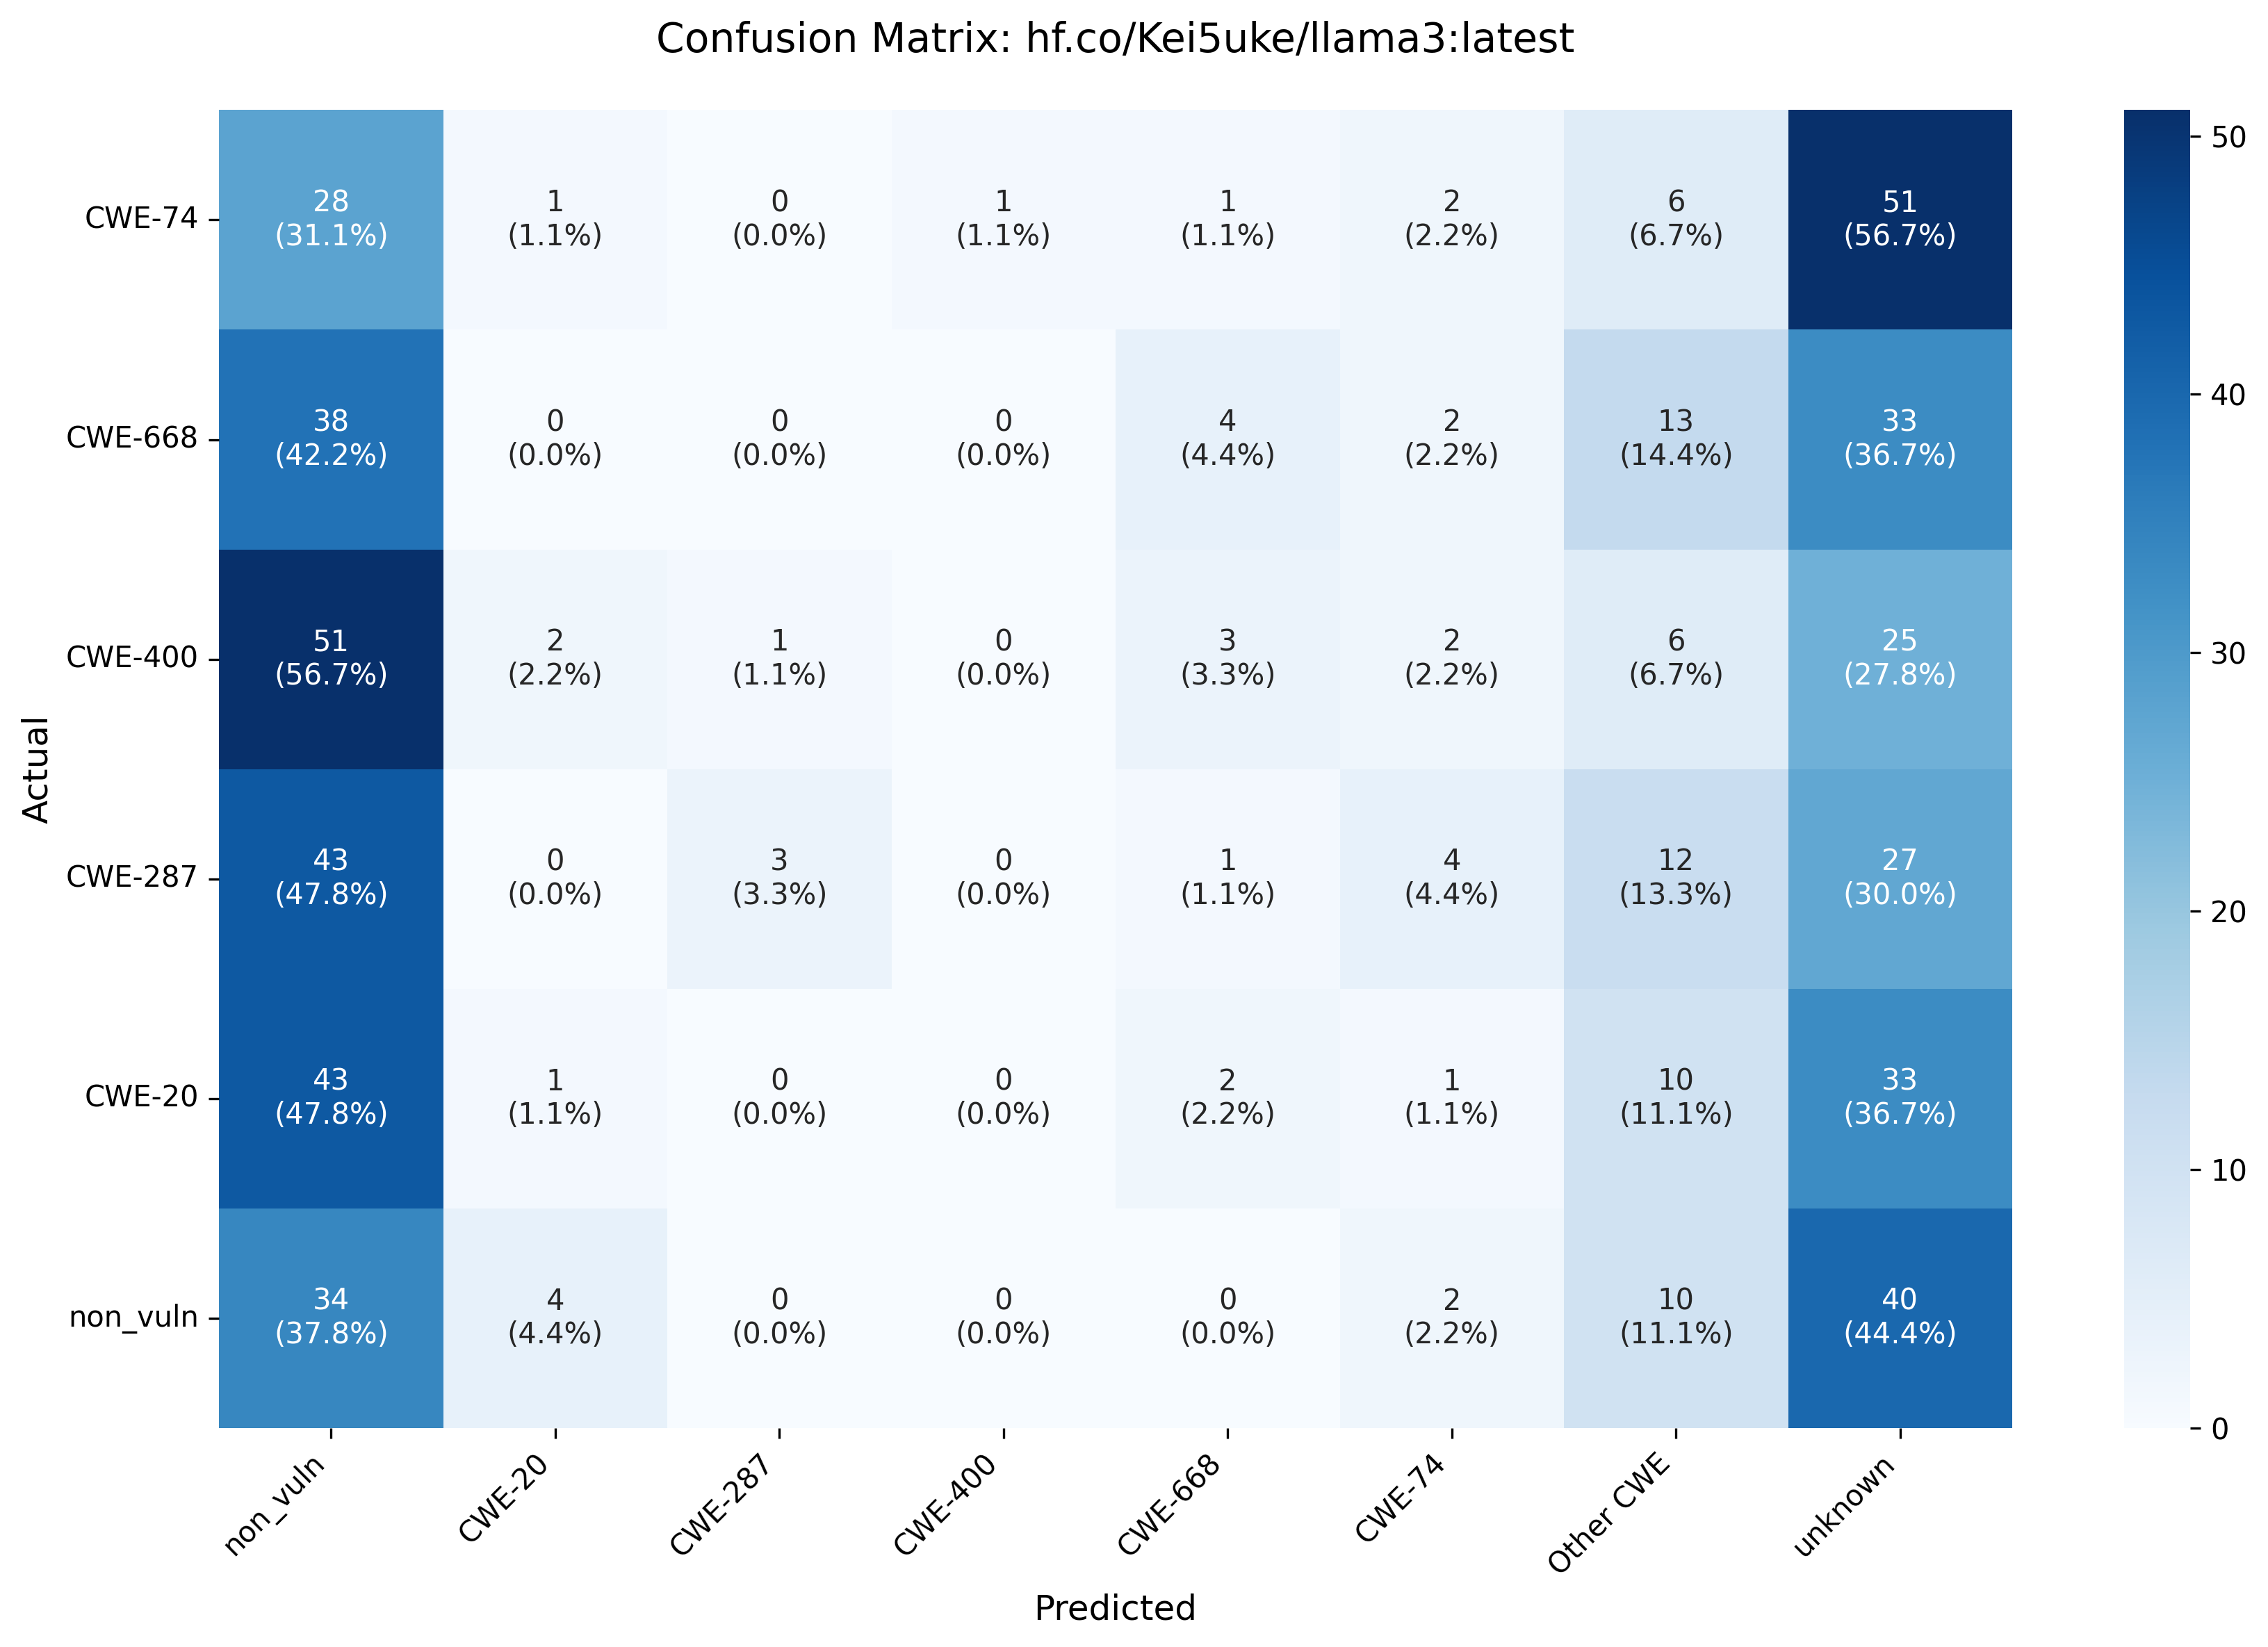

Accuracy: 0.0815
Macro Precision: 0.2560
Macro Recall: 0.0815
Macro F1-score: 0.0684
non_vuln: TP=34.0, FP=203.0, FN=56.0, TN=247.0
CWE-20: TP=1.0, FP=7.0, FN=89.0, TN=443.0
CWE-287: TP=3.0, FP=1.0, FN=87.0, TN=449.0
CWE-400: TP=0.0, FP=1.0, FN=90.0, TN=449.0
CWE-668: TP=4.0, FP=7.0, FN=86.0, TN=443.0
CWE-74: TP=2.0, FP=11.0, FN=88.0, TN=439.0


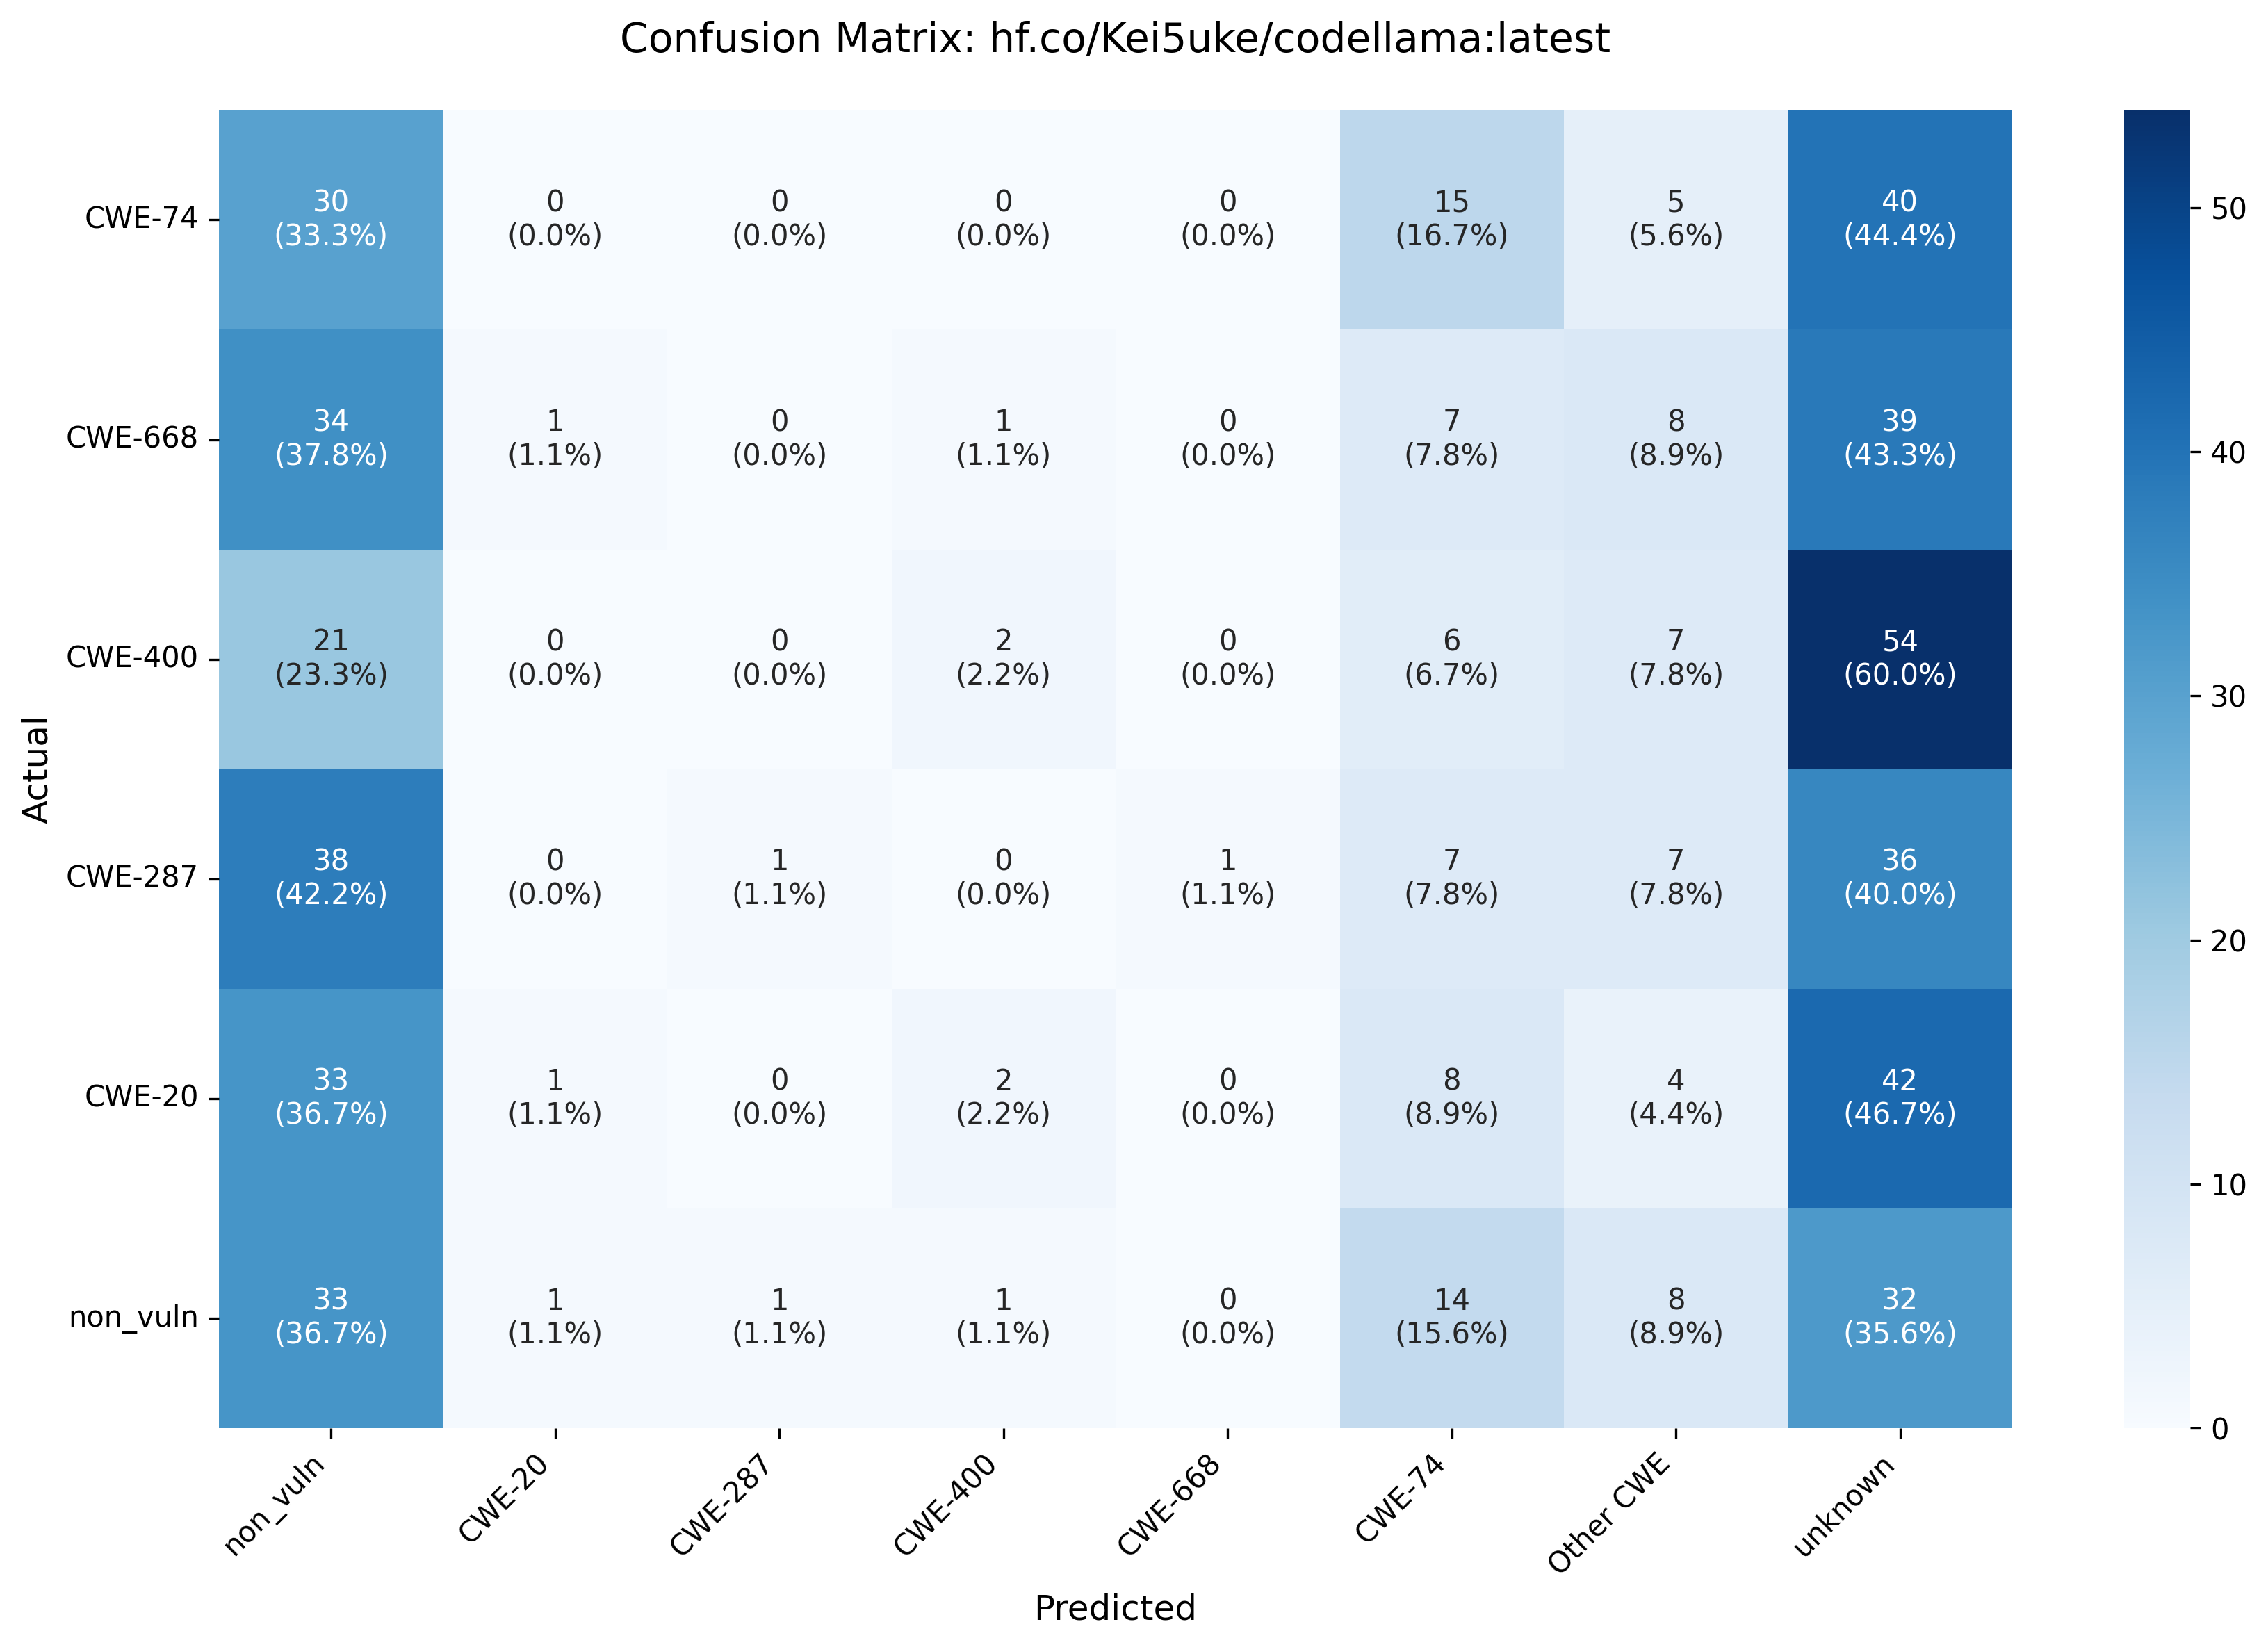

Accuracy: 0.0963
Macro Precision: 0.2674
Macro Recall: 0.0963
Macro F1-score: 0.0876
non_vuln: TP=33.0, FP=156.0, FN=57.0, TN=294.0
CWE-20: TP=1.0, FP=2.0, FN=89.0, TN=448.0
CWE-287: TP=1.0, FP=1.0, FN=89.0, TN=449.0
CWE-400: TP=2.0, FP=4.0, FN=88.0, TN=446.0
CWE-668: TP=0.0, FP=1.0, FN=90.0, TN=449.0
CWE-74: TP=15.0, FP=42.0, FN=75.0, TN=408.0


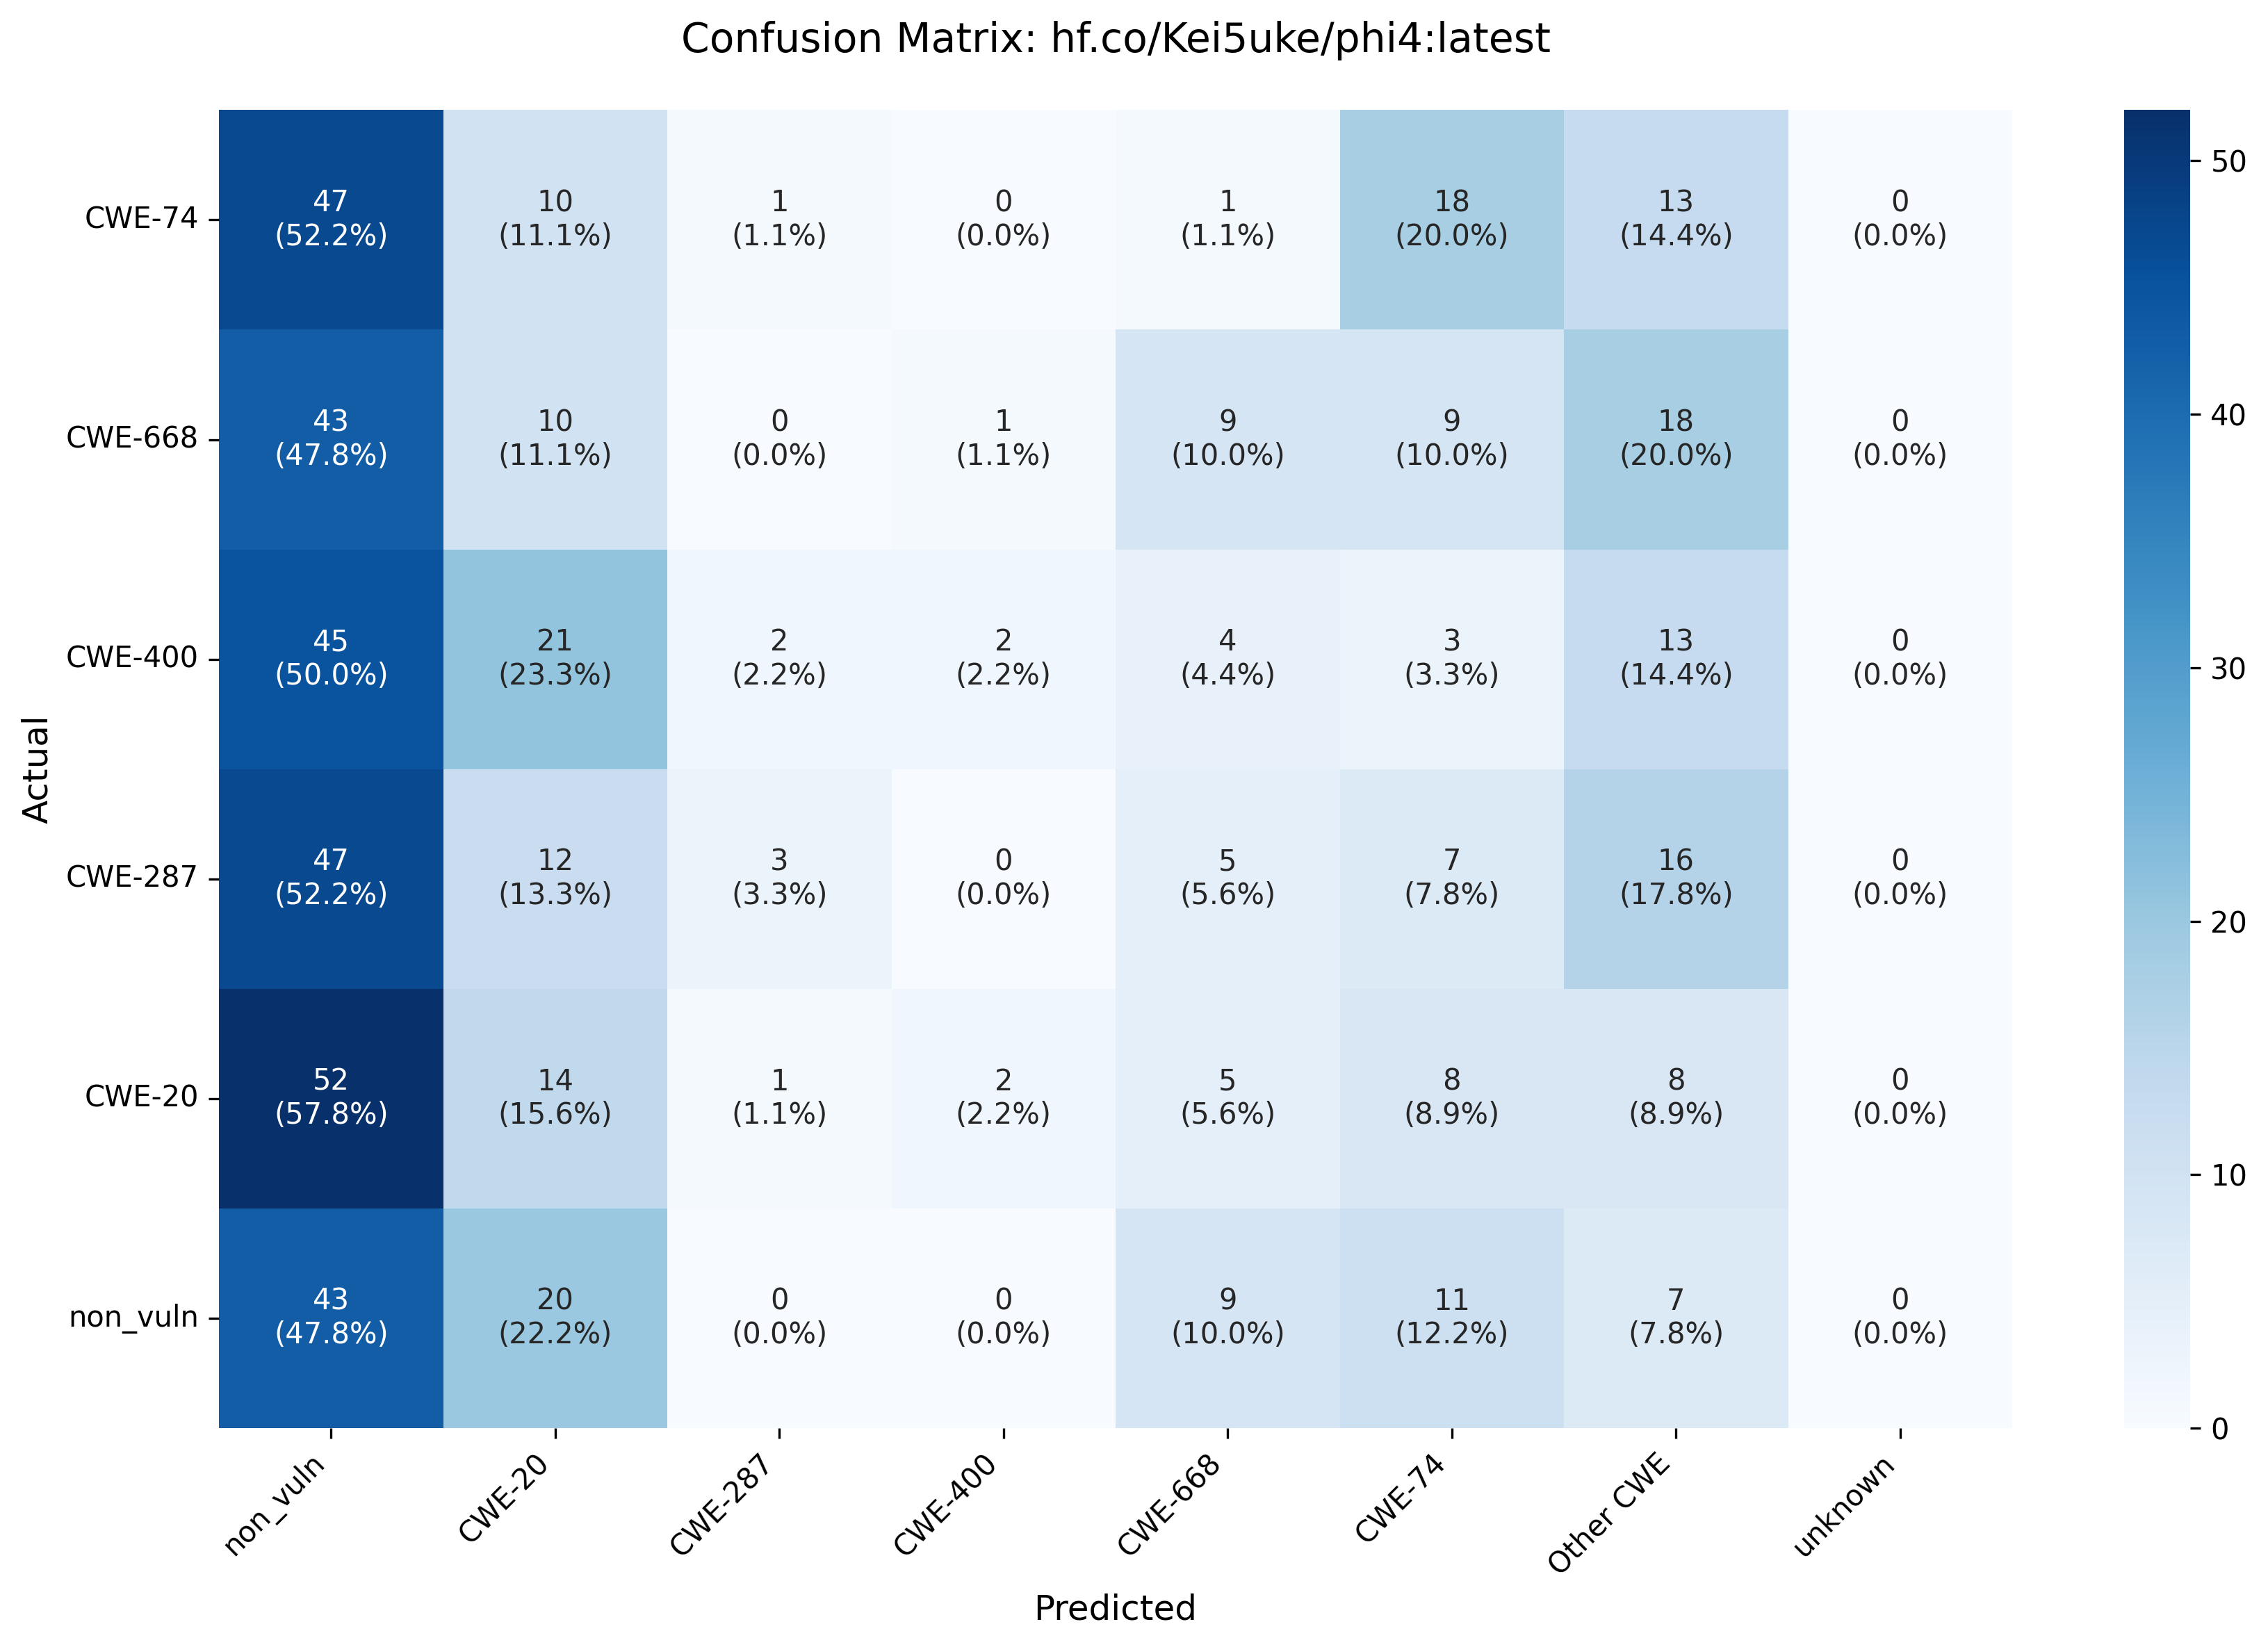

Accuracy: 0.1648
Macro Precision: 0.2898
Macro Recall: 0.1648
Macro F1-score: 0.1482
non_vuln: TP=43.0, FP=234.0, FN=47.0, TN=216.0
CWE-20: TP=14.0, FP=73.0, FN=76.0, TN=377.0
CWE-287: TP=3.0, FP=4.0, FN=87.0, TN=446.0
CWE-400: TP=2.0, FP=3.0, FN=88.0, TN=447.0
CWE-668: TP=9.0, FP=24.0, FN=81.0, TN=426.0
CWE-74: TP=18.0, FP=38.0, FN=72.0, TN=412.0


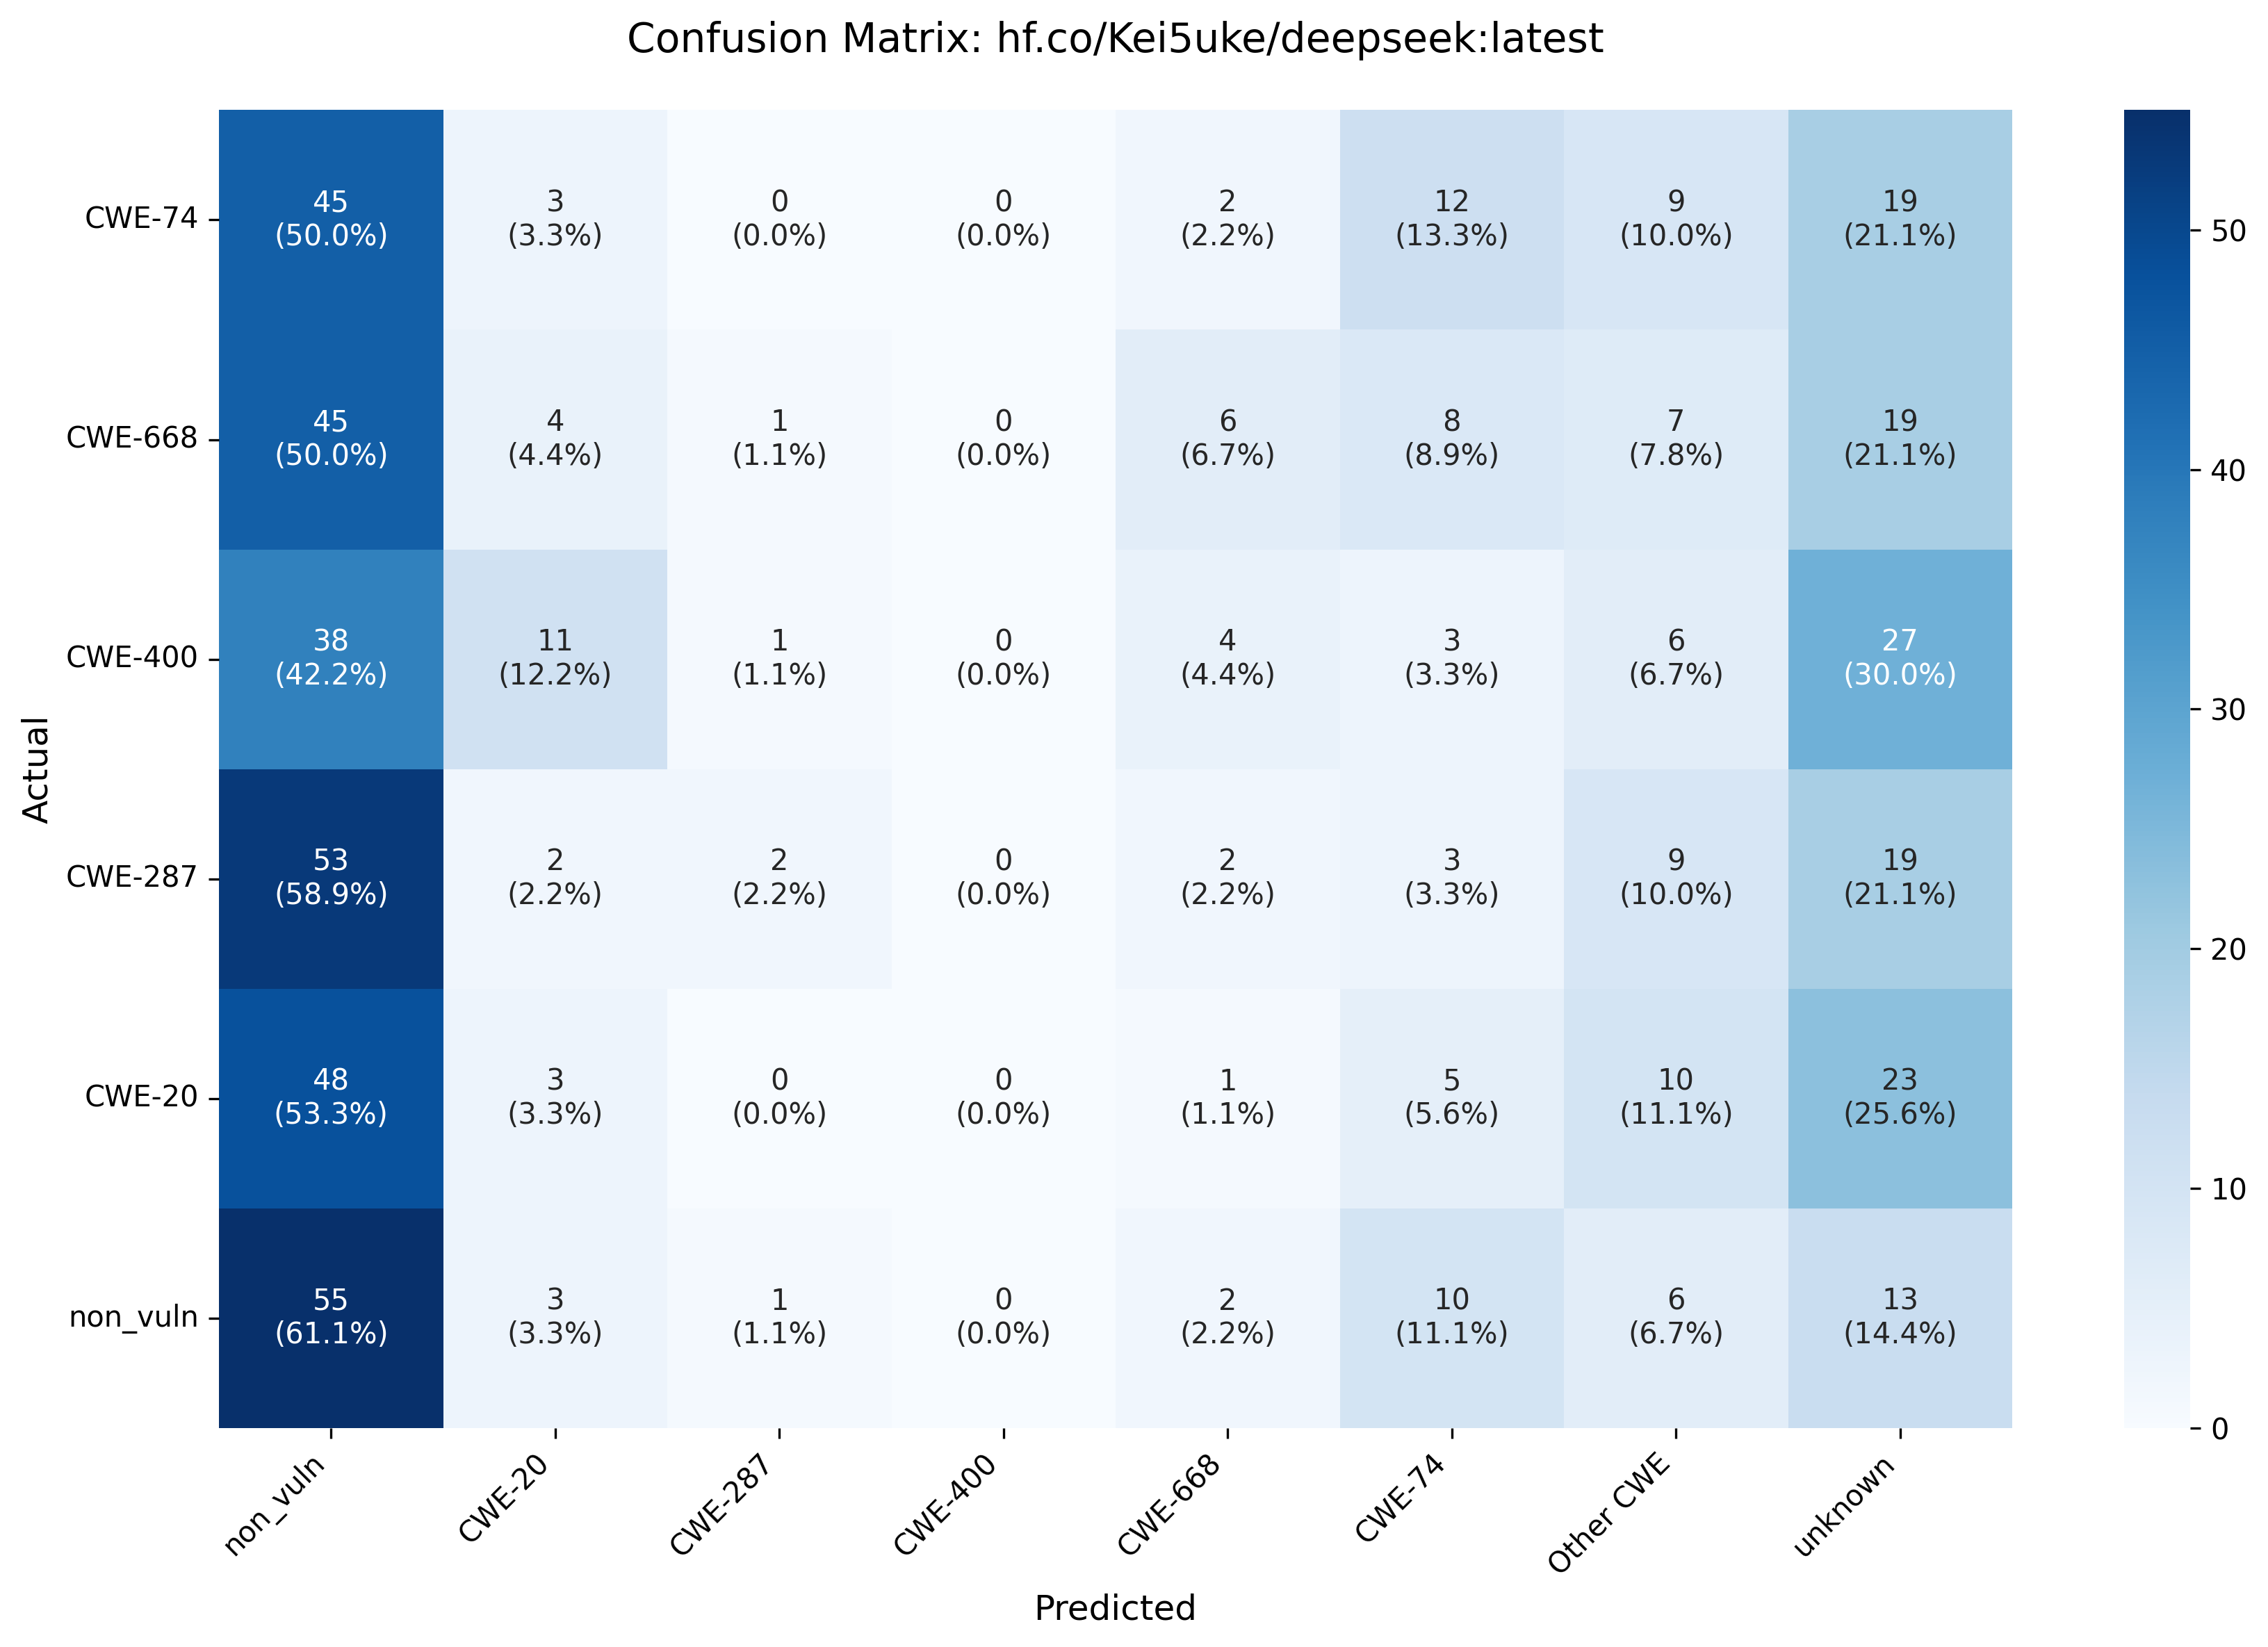

Accuracy: 0.1444
Macro Precision: 0.2258
Macro Recall: 0.1444
Macro F1-score: 0.1139
non_vuln: TP=55.0, FP=229.0, FN=35.0, TN=221.0
CWE-20: TP=3.0, FP=23.0, FN=87.0, TN=427.0
CWE-287: TP=2.0, FP=3.0, FN=88.0, TN=447.0
CWE-400: TP=0.0, FP=0.0, FN=90.0, TN=450.0
CWE-668: TP=6.0, FP=11.0, FN=84.0, TN=439.0
CWE-74: TP=12.0, FP=29.0, FN=78.0, TN=421.0


In [11]:
models = ['hf.co/Kei5uke/llama3:latest', 'hf.co/Kei5uke/codellama:latest', 'hf.co/Kei5uke/phi4:latest', 'hf.co/Kei5uke/deepseek:latest']
main(models, results, find_parents_dict)

In [12]:
def group_results_by_language(results):
    """Group results by programming language."""
    grouped_results = {}
    for r in results:
        lang = r['lang']
        if lang not in grouped_results:
            grouped_results[lang] = []
        grouped_results[lang].append(r)
    return grouped_results

def compute_metrics_by_language(grouped_results, models, find_parents_dict):
    """Compute metrics for each language."""
    all_labels = ['non_vuln','CWE-20','CWE-287','CWE-400','CWE-668','CWE-74','Other CWE','unknown']
    true_labels_order = ['non_vuln','CWE-20','CWE-287','CWE-400','CWE-668','CWE-74']
    pred_labels_order = ['non_vuln','CWE-20','CWE-287','CWE-400','CWE-668','CWE-74','Other CWE','unknown']

    metrics_by_language = {}

    for lang, lang_results in grouped_results.items():
        print(f"\n=== Language: {lang} ===")
        metrics_by_language[lang] = {}

        for model in models:
            print(f"\nModel: {model}")
            true_labels, true_class_labels, pred_labels = extract_labels(lang_results, model)
            unique_cwe_class = map_cwe_to_class(pred_labels, find_parents_dict)

            pred_class_labels = []
            pred_class_labels_filterd = []
            for label in pred_labels:
                if label == 'non_vuln' or label == 'unknown':
                    pred_class_labels.append(label)
                    pred_class_labels_filterd.append(label)
                else:
                    cwe = unique_cwe_class.get(label, 'unknown')
                    pred_class_labels.append(cwe)
                    pred_class_labels_filterd.append(cwe if cwe in np.unique(true_class_labels) else 'Other CWE')

            cm = compute_confusion_matrix(model, true_class_labels, pred_class_labels_filterd, all_labels, False)
            compute_metrics(cm, all_labels, true_labels_order, pred_labels_order)

            # Store metrics for this model and language
            metrics_by_language[lang][model] = {
                'accuracy': np.sum(np.diag(cm)) / np.sum(cm),
                'macro_precision': np.mean([cm[i, i] / (np.sum(cm[:, i]) + 1e-6) for i in range(len(true_labels_order))]),
                'macro_recall': np.mean([cm[i, i] / (np.sum(cm[i, :]) + 1e-6) for i in range(len(true_labels_order))]),
                'macro_f1': np.mean([2 * (cm[i, i] / (np.sum(cm[:, i]) + np.sum(cm[i, :]) + 1e-6)) for i in range(len(true_labels_order))])
            }

    return metrics_by_language

import pandas as pd

def create_metrics_table(metrics_by_language):
    """Create a pandas DataFrame to store metrics by language and model."""
    data = []
    for lang, model_metrics in metrics_by_language.items():
        for model, metrics in model_metrics.items():
            data.append({
                'Language': lang,
                'Model': model,
                'Accuracy': metrics['accuracy'],
                'Macro Precision': metrics['macro_precision'],
                'Macro Recall': metrics['macro_recall'],
                'Macro F1-score': metrics['macro_f1']
            })
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    return df


In [13]:
grouped_results = group_results_by_language(results)
metrics_by_language = compute_metrics_by_language(grouped_results, models, find_parents_dict)
metrics_by_language = compute_metrics_by_language(grouped_results, models, find_parents_dict)
metrics_table = create_metrics_table(metrics_by_language)


print(metrics_table)


=== Language: PHP ===

Model: hf.co/Kei5uke/llama3:latest
Accuracy: 0.0333
Macro Precision: 0.0152
Macro Recall: 0.0333
Macro F1-score: 0.0208
non_vuln: TP=2.0, FP=20.0, FN=8.0, TN=30.0
CWE-20: TP=0.0, FP=0.0, FN=10.0, TN=50.0
CWE-287: TP=0.0, FP=0.0, FN=10.0, TN=50.0
CWE-400: TP=0.0, FP=0.0, FN=10.0, TN=50.0
CWE-668: TP=0.0, FP=1.0, FN=10.0, TN=49.0
CWE-74: TP=0.0, FP=3.0, FN=10.0, TN=47.0

Model: hf.co/Kei5uke/codellama:latest
Accuracy: 0.1000
Macro Precision: 0.0516
Macro Recall: 0.1000
Macro F1-score: 0.0613
non_vuln: TP=5.0, FP=25.0, FN=5.0, TN=25.0
CWE-20: TP=0.0, FP=0.0, FN=10.0, TN=50.0
CWE-287: TP=0.0, FP=1.0, FN=10.0, TN=49.0
CWE-400: TP=0.0, FP=0.0, FN=10.0, TN=50.0
CWE-668: TP=0.0, FP=0.0, FN=10.0, TN=50.0
CWE-74: TP=1.0, FP=6.0, FN=9.0, TN=44.0

Model: hf.co/Kei5uke/phi4:latest
Accuracy: 0.1667
Macro Precision: 0.1218
Macro Recall: 0.1667
Macro F1-score: 0.1289
non_vuln: TP=3.0, FP=17.0, FN=7.0, TN=33.0
CWE-20: TP=1.0, FP=4.0, FN=9.0, TN=46.0
CWE-287: TP=0.0, FP=0.0, FN=1